# Learning uncertain disease effect times using lgpr
Here we generate an artificial longitudinal data set where the exact disease effect time for each case individual is not known.

In [1]:
require(lgpr)
require(repr)
require(ggplot2)
require(ggpubr)

Loading required package: lgpr

Hello, this is lgpr (version 0.28.1).

Loading required package: repr

Loading required package: ggplot2

Loading required package: ggpubr

Loading required package: magrittr



## 1. Simulating data
In this example we generate a data set where the true disease effect times for each case individual $q = 1, \ldots, 6$ are drawn from $\mathcal{N}(36, 4^2)$, but the disease initiation is observable only after time $t_q$, which is drawn from $t_q \sim \text{Exponential}(0.05)$. 

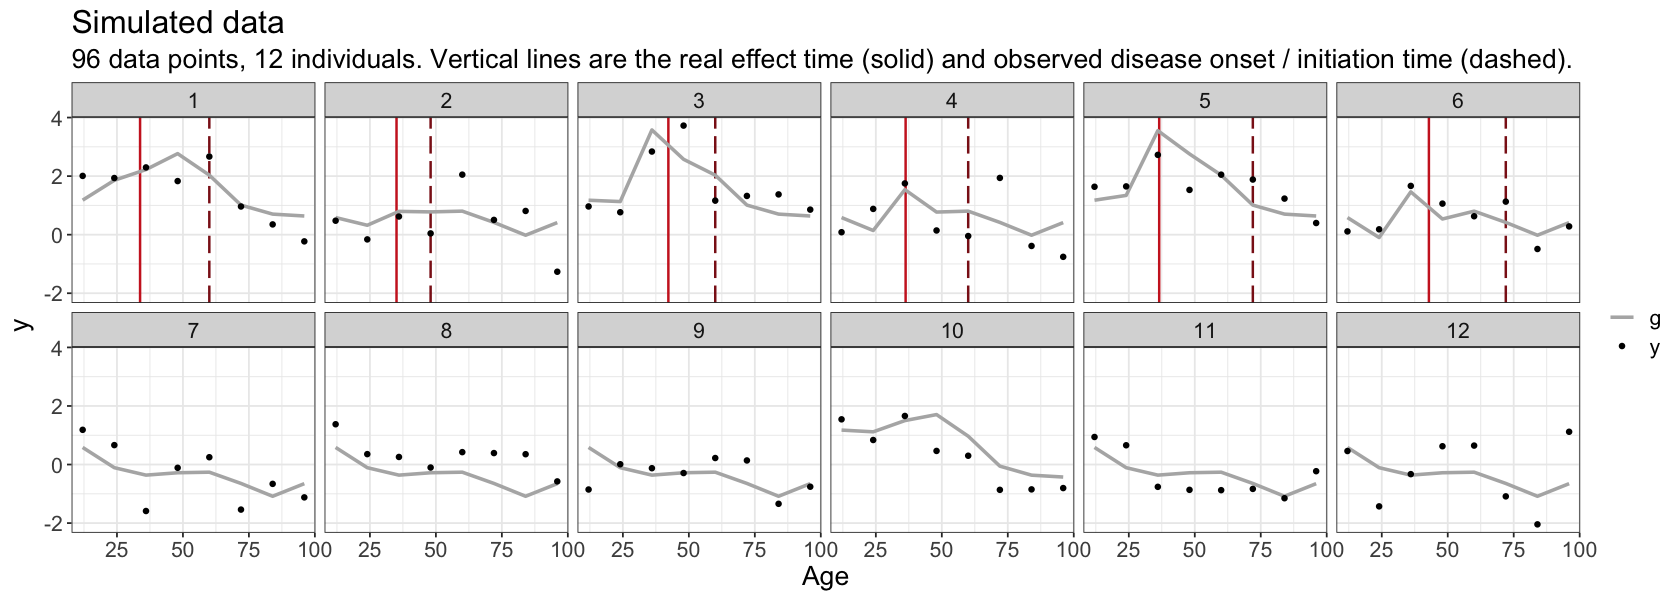

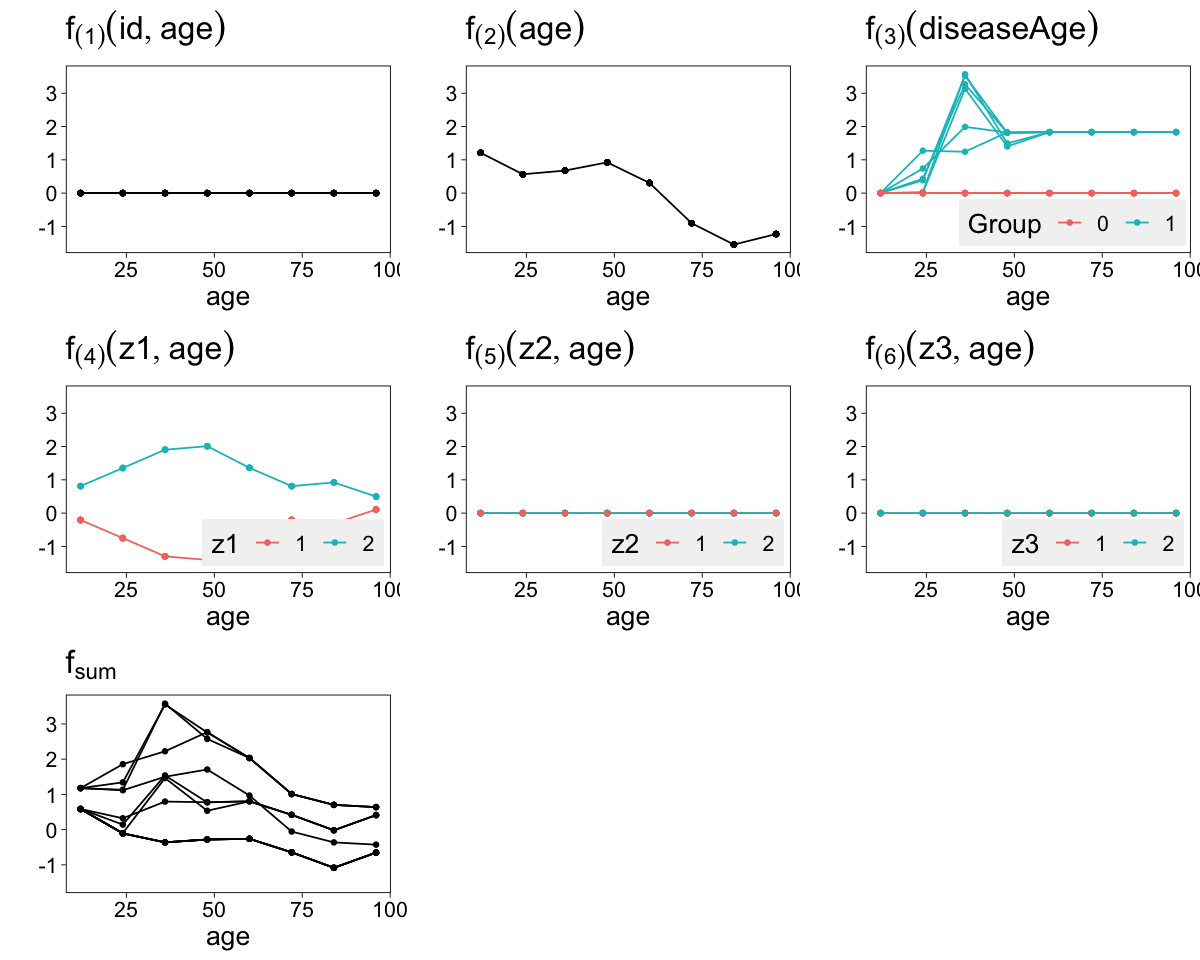

In [2]:
set.seed(123)
relev           <- c(0,1,1,1,0,0)
effect_time_fun <- function(){rnorm(n = 1, mean = 36, sd = 4)}
obs_fun         <- function(t){min(t + stats::rexp(n = 1, rate = 0.05), 96 - 1e-5)}
  
simData <- simulate_data(N            = 12,
                         t_data       = seq(12, 96, by = 12),
                         covariates   = c(    0,2,2,2),
                         relevances   = relev,
                         lengthscales = c(18,24, 1, 18,18,18),
                         t_effect_range = effect_time_fun,
                         t_observed   = obs_fun,
                         snr          = 2)
  

FONT_SIZE <- 16
options(repr.plot.width=14, repr.plot.height=5)
plot_simdata(simData, nrow = 2, ncol = 6) + theme(text=element_text(size=FONT_SIZE)) 
options(repr.plot.width=10, repr.plot.height=8)
plot_components_simdata(simData, font_size = FONT_SIZE)
data <- simData$data

## 2. Fitting models
We fit two models. One where the effect times is fixed to the observed disease initiation times and one where the effect times have uncertainty.

In [3]:
p1 <- prior_default()
f1 <- lgp(formula   = y ~ id + age + diseaseAge + z1 + z2 + z3,
            data     = data,
            prior    = p1,
            iter     = 2000,
            chains   = 4,
            uncertain_effect_time = FALSE,
            parallel = TRUE,
            verbose  = TRUE)

p2 <- prior_default()
#p2$effect_time <- list(type="gamma_before_backwards", shape = 1, rate = 0.05)
f2 <- lgp(formula    = y ~ id + age + diseaseAge + z1 + z2 + z3,
            data     = data,
            prior    = p2,
            iter     = 2000,
            chains   = 4,
            uncertain_effect_time = TRUE,
            parallel = TRUE,
            verbose  = TRUE) 


* Interpreting 'diseaseAge' as the disease-related age variable.
* Covariate 'z1' resolved to type 'categorical'.
* Covariate 'z2' resolved to type 'categorical'.
* Covariate 'z3' resolved to type 'categorical'.

 ---------- LGPMODEL SUMMARY ----------

  Model:
    f = f[(1)](id, age) + f[(2)](age) + f[(3)](diseaseAge) + f[(4)](z1, age) + f[(5)](z2, age) + f[(6)](z3, age)
    Response variable: y
    Observation model: Gaussian 
  Variable types:
    - Identifier variable: id
    - Time variable: age
    - Disease-related age variable: diseaseAge
    - Other categorical variables: z1, z2, z3
  Observation model: Gaussian
  Disease component 
    - Effect time: fixed
    - Effect type: homogeneous

 ---------- PRIOR SPECIFICATIONS ----------

  alpha_id ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_age ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_diseaseAge ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_categAge[1] ~ Student-t(nu=20,mu=0,sigma=1)
  alpha_categAge[2] ~ Student-t(nu=20,mu=0,sigma=1)
  alp

## 3. Visualization

In [ ]:
# prediction 
t_test <- seq(0, 100, length.out=100)
X_test <- create_test_points(f1, t_test)
PRED1 <- lgp_predict(f1, X_test, samples = "mean")
PRED2 <- lgp_predict(f2, X_test, samples = "mean")

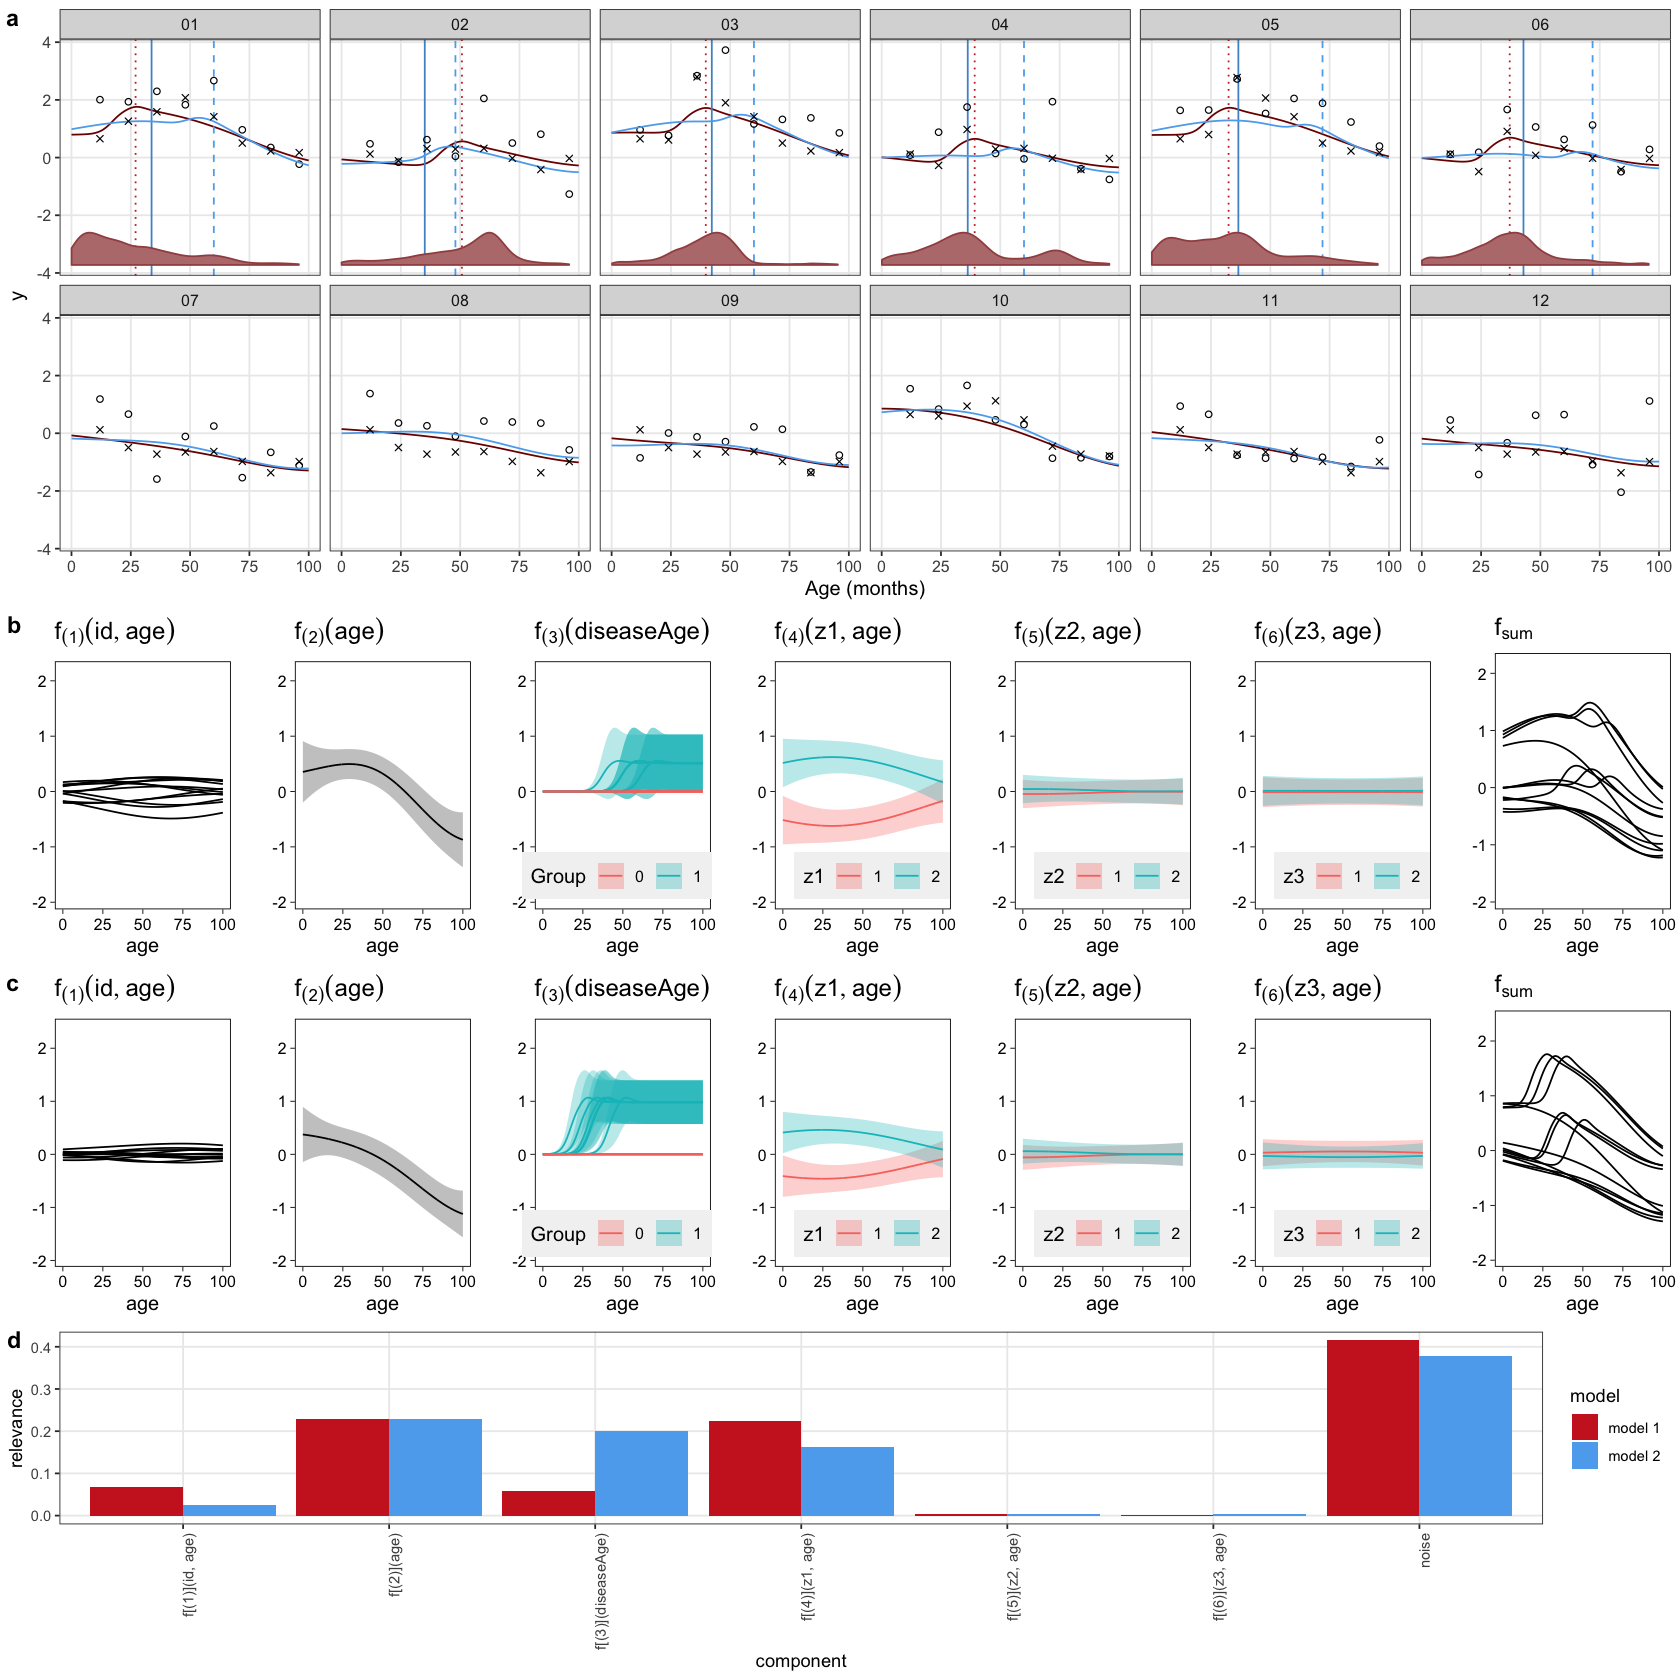

In [20]:
# create plot
p1 <- lgpr:::plot_posterior_predictions(f2, PRED = PRED2, mode = "predictive", 
                                        plot_t_effect_samples = TRUE, plot_obs_onset = TRUE,
                                        reference_times = simData$onsets,
                                        plot_uncertainty = FALSE,
                                        post_t_effect_stat = "mean",
                                        original_y_scale = FALSE,
                                        color_scheme_t_effect = "red",
                                        ons_linecolors = c("steelblue3", "steelblue2", "firebrick3"),
                                        data_marker = 21) +
  theme_bw() +
  facet_wrap(~ facet_var, nrow = 2) +
  theme(panel.grid.minor = element_blank())

# Add other model's fit
id1    <- PRED1$X_test_scaled$id
fv     <- formatC(id1, flag = "0", width = 2)
age1   <- X_test[,2]
mu1    <- PRED1$LIST[[1]]$mu_f
df_add <- data.frame(fv, id1, age1, mu1)
colnames(df_add) <- c("facet_var", "id", "age", "mu_pred")
p1     <- p1 + geom_line(data = df_add, aes(x=age, y=mu_pred), lty=1, color = "steelblue2")
p1     <- p1 + xlab("Age (months)") + ylab("y") + theme(plot.title = element_blank())

# Add real generating process
f       <- simData$components$f
age     <- simData$data$age
id      <- simData$data$id
YSCL    <- f1@model@scalings$YSCL
f       <- YSCL$fun(f)
facet_var <- formatC(id, flag = "0", width = 2)
df_real <- data.frame(id, age, f, facet_var)
p1      <- p1 + geom_point(data = df_real, aes(x=age, y=f), pch = 4)


FONT_SIZE <- 12
p1 <- p1 + theme(text=element_text(size=FONT_SIZE)) 
p2 <- plot_components_posterior(f1, PRED = PRED1, font_size = FONT_SIZE, nrow = 1, ncol = 7)
p3 <- plot_components_posterior(f2, PRED = PRED2, font_size = FONT_SIZE, nrow = 1, ncol = 7)

# Plot covariate relevances
r1  <- f1@relevances$average
r2  <- f2@relevances$average
m   <- as.factor(rep(c("model 1", "model 2"), each = 7))
h   <- c(r1,r2)
df  <- data.frame(names(h), h, m)
colnames(df) <- c("component", "relevance", "model")

bar <- ggplot(df, aes(x = component, y = relevance, fill = model, group = model)) +
  geom_bar(stat = "identity", position = position_dodge()) + theme_bw() +
  theme(panel.grid.minor = element_blank()) + 
  scale_fill_manual(values=c('firebrick3','steelblue2')) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))


full <- ggarrange(p1, p2, p3, bar, nrow = 4, labels = "auto", heights = c(1.7,1,1,1))

options(repr.plot.width=14, repr.plot.height=14)
full